# Data cleaning

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("thyroid.csv")

#replacing '?'
df = df.applymap(lambda x: np.nan if str(x).strip() == '?' else x)

#replacing categorical variables
df.replace({'f':0,'t':1}, inplace = True)
df.sex.replace({'F': 1, 'M': 0}, inplace = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5581 entries, 0 to 5580
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        5581 non-null   int64  
 1   sex                        5363 non-null   float64
 2   TSH                        5014 non-null   object 
 3   T3                         4411 non-null   object 
 4   TT4                        5213 non-null   object 
 5   T4U                        4987 non-null   object 
 6   FTI                        4991 non-null   object 
 7   on_thyroxine               5581 non-null   int64  
 8   query_on_thyroxine         5581 non-null   int64  
 9   on_antithyroid_medication  5581 non-null   int64  
 10  sick                       5581 non-null   int64  
 11  pregnant                   5581 non-null   int64  
 12  thyroid_surgery            5581 non-null   int64  
 13  I131_treatment             5581 non-null   int64

# Filling missing values

In [2]:
print(round(df.sex.mode()))

0    1.0
Name: sex, dtype: float64


In [3]:
#filling missing values in sex column
df.sex.fillna(round(df.sex.mode()[0]),inplace = True)

In [4]:
df.isnull().sum()

age                             0
sex                             0
TSH                           567
T3                           1170
TT4                           368
T4U                           594
FTI                           590
on_thyroxine                    0
query_on_thyroxine              0
on_antithyroid_medication       0
sick                            0
pregnant                        0
thyroid_surgery                 0
I131_treatment                  0
query_hypothyroid               0
query_hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
Class                           0
dtype: int64

In [5]:
import warnings

In [6]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder

# Changing 'Class' column categorical varibales to numeric data
label_encoder = LabelEncoder()
df['Class'] = label_encoder.fit_transform(df['Class'])

# Use IterativeImputer to fill missing data
imputer = IterativeImputer(missing_values = np.nan, n_nearest_features = 5, random_state = 0)
imputer.fit(df)
data_imputed = imputer.transform(df)

# Converting imputed data to dataframe
data_imputed = pd.DataFrame(data_imputed, columns = df.columns)

# Inverse transform Label Encoding to get the actual 'Class' values
data_imputed['Class'] = data_imputed['Class'].astype(int)
data_imputed['Class'] = label_encoder.inverse_transform(data_imputed['Class'])

warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [7]:
original_labels = label_encoder.classes_

for index, original in enumerate(original_labels):
    print(f'{index} - {original}')

0 - compensated hypothyroid
1 - hyperthyroid
2 - negative
3 - primary hypothyroid
4 - secondary hypothyroid


In [8]:
df = data_imputed
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5581 entries, 0 to 5580
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        5581 non-null   float64
 1   sex                        5581 non-null   float64
 2   TSH                        5581 non-null   float64
 3   T3                         5581 non-null   float64
 4   TT4                        5581 non-null   float64
 5   T4U                        5581 non-null   float64
 6   FTI                        5581 non-null   float64
 7   on_thyroxine               5581 non-null   float64
 8   query_on_thyroxine         5581 non-null   float64
 9   on_antithyroid_medication  5581 non-null   float64
 10  sick                       5581 non-null   float64
 11  pregnant                   5581 non-null   float64
 12  thyroid_surgery            5581 non-null   float64
 13  I131_treatment             5581 non-null   float

# Outliers

<Axes: xlabel='Class', ylabel='FTI'>

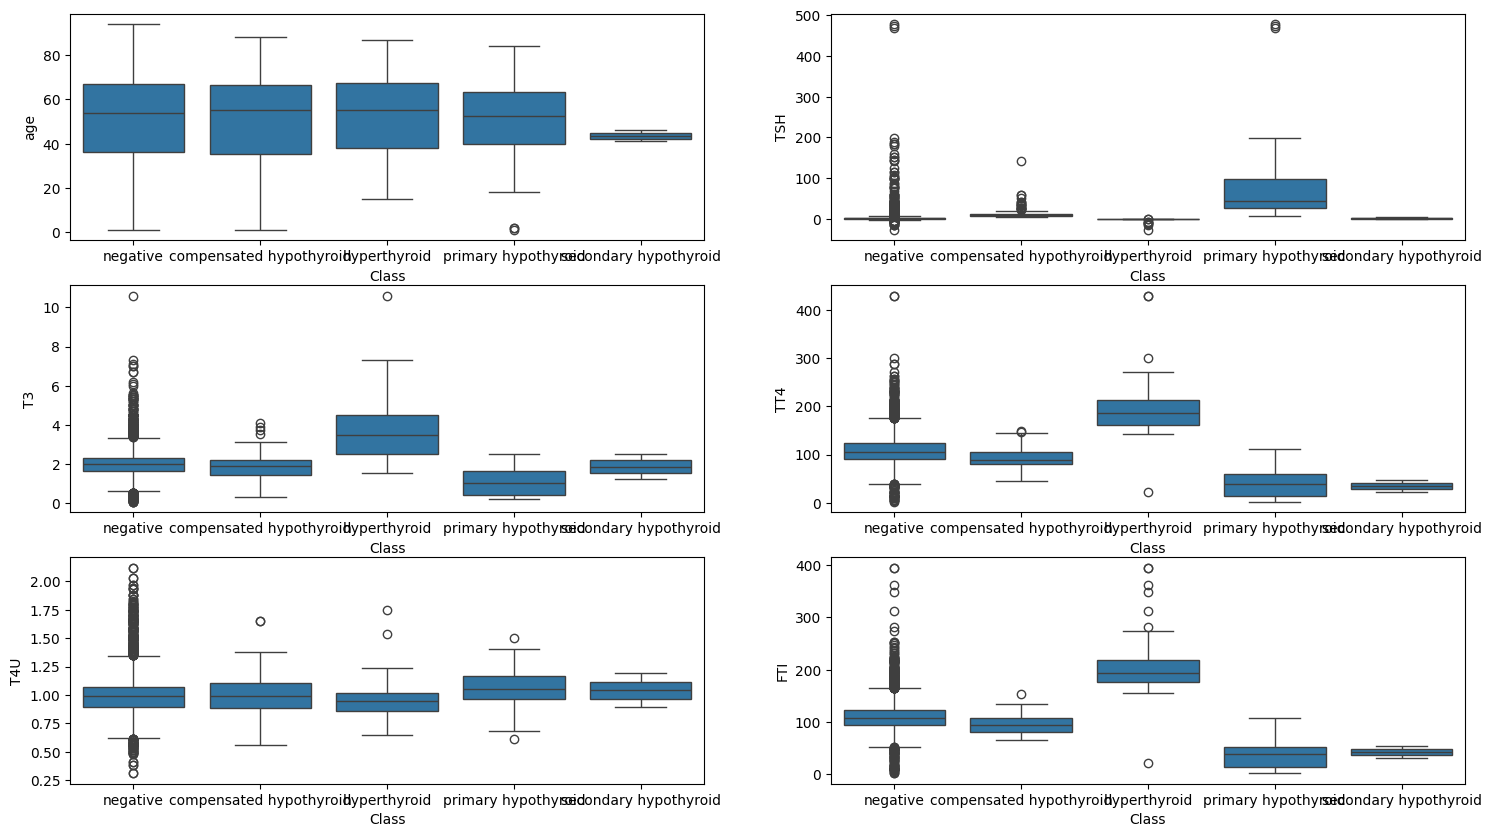

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(3,2, figsize=(18, 10))

sns.boxplot(ax=axes[0, 0], data=df, x='Class', y='age')
sns.boxplot(ax=axes[0, 1], data=df, x='Class', y='TSH')
sns.boxplot(ax=axes[1, 0], data=df, x='Class', y='T3')
sns.boxplot(ax=axes[1, 1], data=df, x='Class', y='TT4')
sns.boxplot(ax=axes[2, 0], data=df, x='Class', y='T4U')
sns.boxplot(ax=axes[2, 1], data=df, x='Class', y='FTI')

In [10]:
# Replacing outliers in the 'negative' class
features = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']

for i, feature in enumerate(features):
    negative_mean = df[df['Class'] == 'negative'][feature].mean()
    negative_data = df[(df['Class'] == 'negative') & (df[feature] != negative_mean)]

    #Checking z_score
    z_threshold = 2
    z_scores = (negative_data[feature] - negative_mean) / negative_data[feature].std()
    is_outlier = abs(z_scores) > z_threshold
    negative_data.loc[is_outlier, feature] = negative_mean

    # Updating the original values
    df.update(negative_data)

In [11]:
df.drop(['FTI','T4U'], axis = 1, inplace = True)

# Exploratory Data Analysis

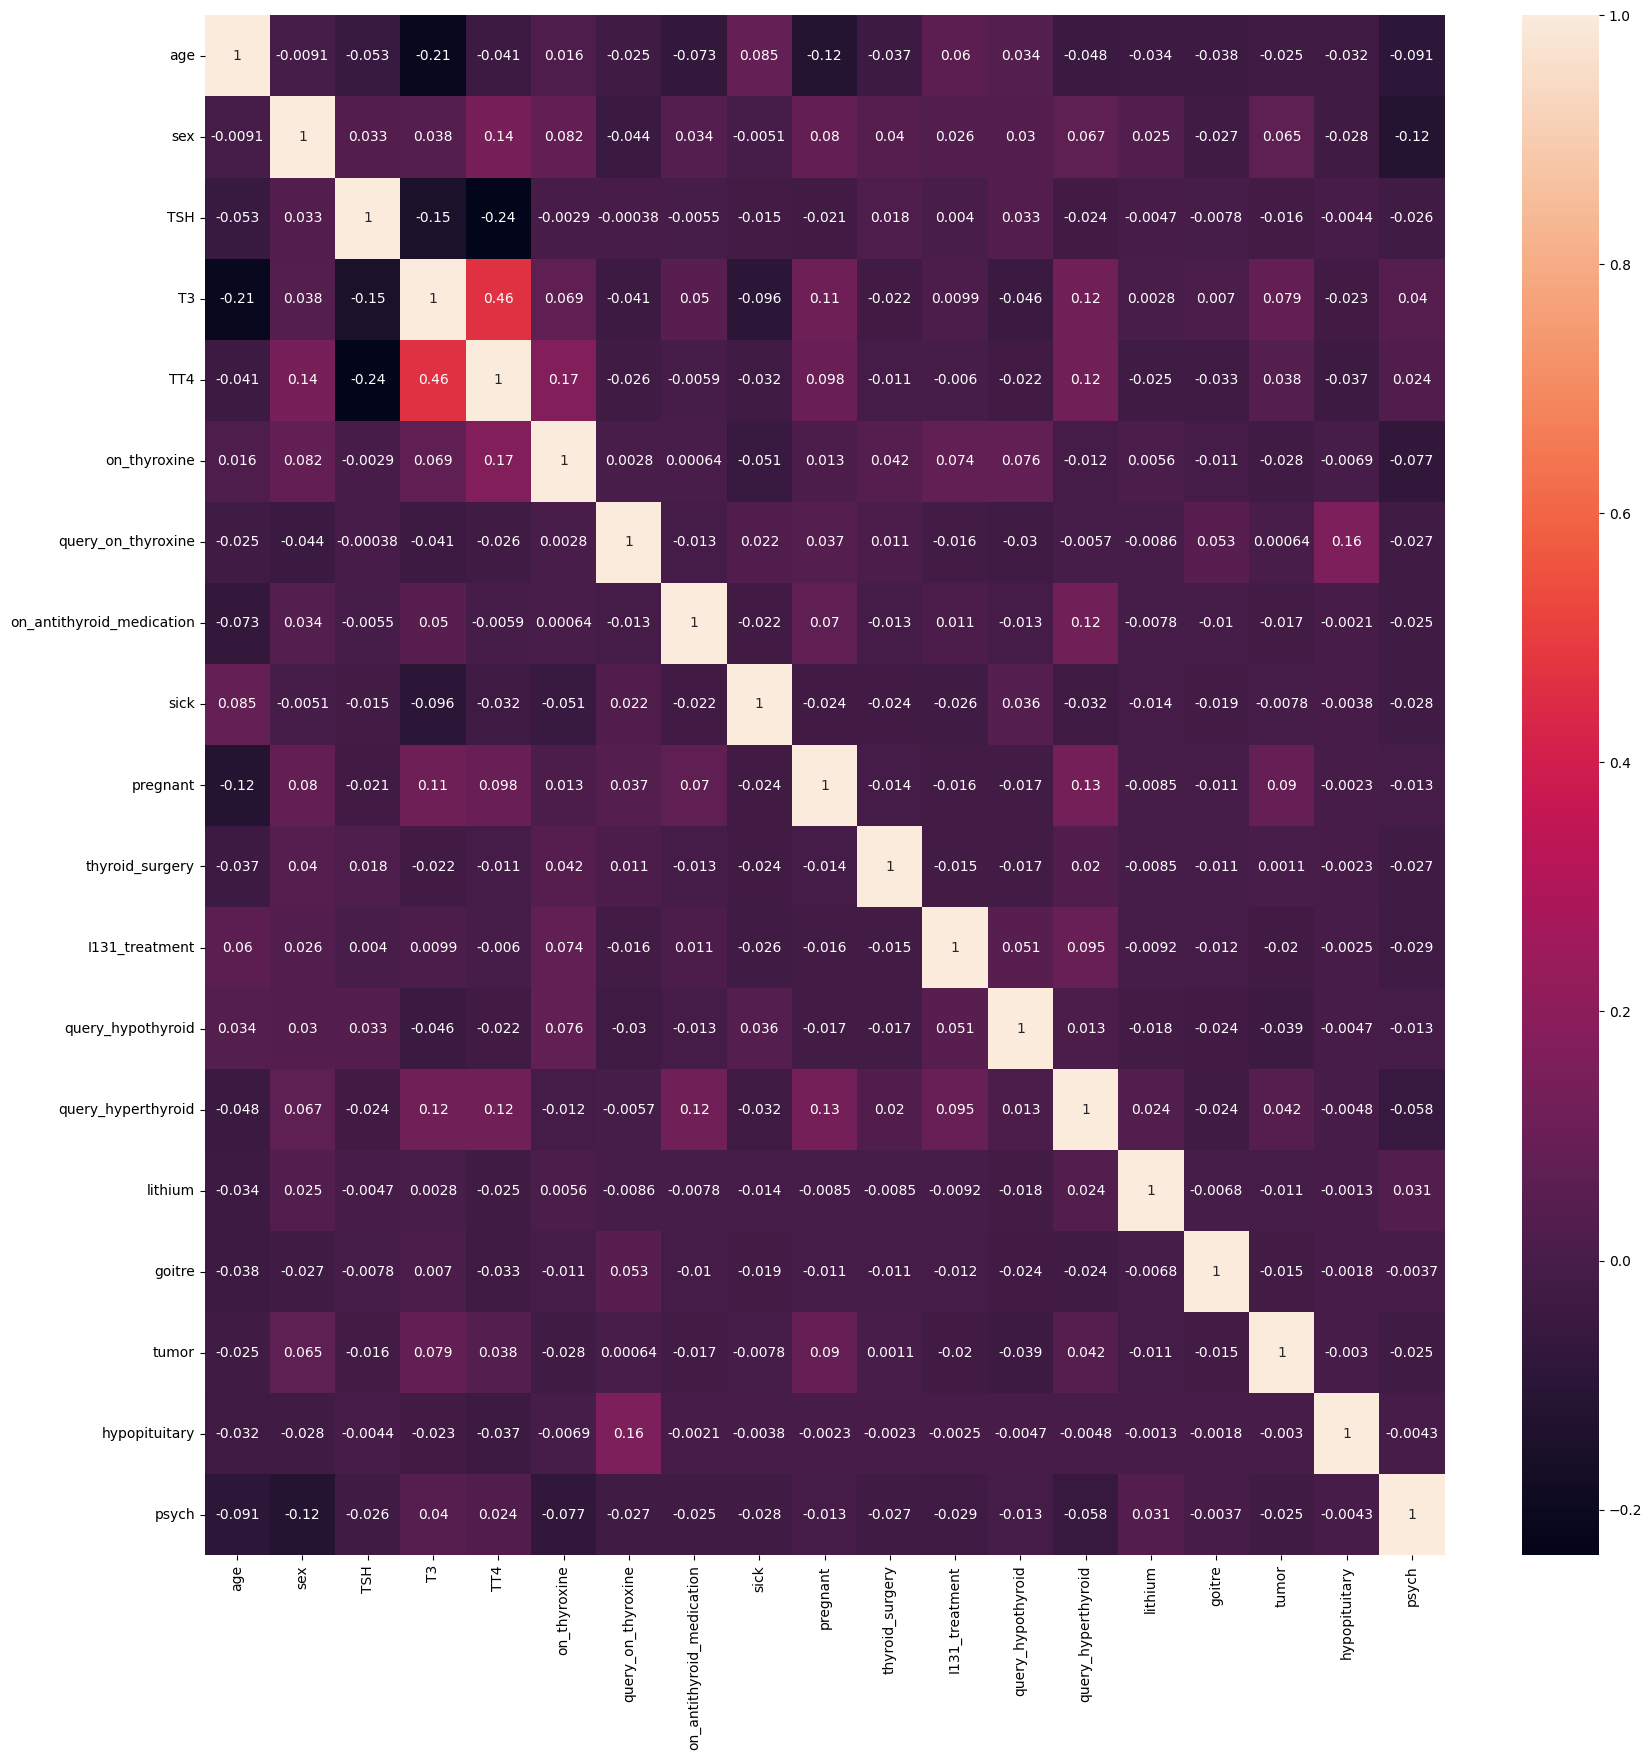

In [12]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),annot=True)
warnings.filterwarnings('ignore')

# Feature Selection

In [13]:
X = df.drop('Class', axis = 1)
y = df['Class']

In [14]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X, y)

RandomForestClassifier()

In [15]:
feature_importances = rf_model.feature_importances_
feature_importances

array([9.89220717e-02, 8.22888709e-03, 3.28307504e-01, 2.19916818e-01,
       2.93511660e-01, 1.29623651e-02, 3.79597141e-03, 1.04474669e-03,
       4.50465345e-03, 9.74018236e-04, 3.01252328e-03, 2.61193405e-03,
       7.14361745e-03, 5.32492336e-03, 8.90340503e-04, 6.89447734e-04,
       3.89079567e-03, 2.33618813e-07, 4.26748830e-03])

In [16]:
threshold = 0.001
selected_features = np.where(feature_importances < threshold)[0]
selected_features

array([ 9, 14, 15, 17])

In [18]:
for index, col in enumerate(df.columns):
  print(f"{index} - {col}")

0 - age
1 - sex
2 - TSH
3 - T3
4 - TT4
5 - on_thyroxine
6 - query_on_thyroxine
7 - on_antithyroid_medication
8 - sick
9 - pregnant
10 - thyroid_surgery
11 - I131_treatment
12 - query_hypothyroid
13 - query_hyperthyroid
14 - lithium
15 - goitre
16 - tumor
17 - hypopituitary
18 - psych
19 - Class


In [19]:
df.drop(['lithium', 'goitre', 'hypopituitary'], axis = 1, inplace = True)

# Data Augmentation


In [20]:
df['Class'].value_counts()

negative                   5299
compensated hypothyroid     154
primary hypothyroid          64
hyperthyroid                 62
secondary hypothyroid         2
Name: Class, dtype: int64

In [21]:
X = df.drop('Class', axis = 1)
y = df['Class']

In [22]:
from imblearn.over_sampling import SMOTE

# Applying SMOTE to the training  and testind data seperately
smote = SMOTE(sampling_strategy={'negative': 5299, 'compensated hypothyroid': 5299,
                                 'hyperthyroid': 5299, 'primary hypothyroid': 5299,
                                 'secondary hypothyroid': 5299},
              k_neighbors=1, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [23]:
y_resampled.value_counts()

negative                   5299
compensated hypothyroid    5299
hyperthyroid               5299
primary hypothyroid        5299
secondary hypothyroid      5299
Name: Class, dtype: int64

In [24]:
X_resampled.shape, y_resampled.shape

((26495, 16), (26495,))

In [25]:
new_df = pd.DataFrame(X_resampled, columns=X.columns)
new_df['Class'] = y_resampled
new_df.to_csv("thyroid_sample.csv", index = False)

# Data Splitting

In [26]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [27]:
from sklearn.model_selection import train_test_split

# Spliting the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
y_test.value_counts()

negative                   1086
hyperthyroid               1066
secondary hypothyroid      1065
compensated hypothyroid    1044
primary hypothyroid        1038
Name: Class, dtype: int64

In [29]:
y_train.value_counts()

primary hypothyroid        4261
compensated hypothyroid    4255
secondary hypothyroid      4234
hyperthyroid               4233
negative                   4213
Name: Class, dtype: int64

# Feature scaling


In [30]:
from sklearn.preprocessing import MinMaxScaler

# Scaling features to handle negative values
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
X_train_scaled.shape, y_train.shape, X_test_scaled.shape, y_test.shape

((21196, 16), (21196,), (5299, 16), (5299,))

# Model Selection

In [32]:
X_train = X_train_scaled
X_test = X_test_scaled

In [33]:
X_train

array([[0.44108175, 1.        , 0.05274456, ..., 1.        , 0.        ,
        0.        ],
       [0.79911254, 0.10730121, 0.06849576, ..., 0.        , 0.        ,
        0.        ],
       [0.43181818, 1.        , 0.052898  , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.80681818, 1.        , 0.05279888, ..., 0.        , 0.        ,
        0.        ],
       [0.6052457 , 0.75105648, 0.05241971, ..., 0.24894352, 0.        ,
        0.        ],
       [0.47629434, 0.38278042, 0.05591138, ..., 0.        , 0.        ,
        0.        ]])

In [34]:
from sklearn.metrics import accuracy_score

In [35]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=3)
clf = tree.fit(X_train,y_train)
treepredict = clf.predict(X_test)
accuracy_score(treepredict,y_test)

0.9386676731458766

In [37]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
r_model = RandomForestClassifier()
r_model.fit(X_train, y_train)
accuracy = r_model.score(X_test, y_test)
accuracy

0.9873561049254577

In [38]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
knnclf = neigh.fit(X_train,y_train)
y_pred = knnclf.predict(X_test)
accuracy_score(y_pred,y_test)

0.9841479524438573

In [39]:
from xgboost import XGBClassifier
# Label encoding the y
label_encoder = LabelEncoder()
y_test.value_counts()

negative                   1086
hyperthyroid               1066
secondary hypothyroid      1065
compensated hypothyroid    1044
primary hypothyroid        1038
Name: Class, dtype: int64

In [40]:
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [41]:
#XGBoost
xgb = XGBClassifier()
xgb.fit(X_train, y_train_encoded)
y_pred_xgb = xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
accuracy_xgb

0.9875448197773165

# Model training


In [42]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train_encoded)
xgb_preds = xgb_model.predict(X_test)

In [43]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train_encoded)
knn_preds = knn_model.predict(X_test)

In [44]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train_encoded)
rf_preds = rf_model.predict(X_test)

# Hyper-parameter tuning

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

In [47]:
#XGBoost
param_dist = {'learning_rate': [0.1, 0.3, 0.5],'n_estimators': randint(100, 300),'max_depth': randint(3, 7)}
random_search_xgb = RandomizedSearchCV(XGBClassifier(), param_distributions=param_dist, cv=5, n_iter=10, random_state = 42)
random_search_xgb.fit(X_train, y_train_encoded)
print(random_search_xgb.best_params_)

{'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 257}


In [49]:
#KNN
np.random.seed(42)
param_grid_knn = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knn, cv=5)
grid_search_knn.fit(X_train, y_train_encoded)
print(grid_search_knn.best_params_)

{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


In [50]:
#Random Forest
np.random.seed(42)
param_dist_rf = {'n_estimators': randint(100, 300),'max_depth': randint(5, 15),'max_features': ['sqrt']}
random_search_rf = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist_rf, n_iter=10, cv=5)
random_search_rf.fit(X_train, y_train_encoded)
print(random_search_rf.best_params_)

{'max_depth': 14, 'max_features': 'sqrt', 'n_estimators': 174}


# Model Re-training

In [51]:
best_rf = RandomForestClassifier(max_depth=14, max_features='sqrt', n_estimators=174)
best_rf.fit(X_train, y_train_encoded)
rf_preds = best_rf.predict(X_test)

In [52]:
best_knn = KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')
best_knn.fit(X_train, y_train_encoded)
knn_preds = best_knn.predict(X_test)

In [53]:
best_xgb = XGBClassifier(learning_rate=0.3, max_depth=6, n_estimators=257)
best_xgb.fit(X_train, y_train_encoded)
xgb_preds = best_xgb.predict(X_test)

# Model Evaluation


In [54]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

In [55]:
#0 - compensated hypothyroid
#1 - hyperthyroid
#2 - negative
#3 - primary hypothyroid
#4 - secondary hypothyroid

In [56]:
#Accuracy
test_accuracy = accuracy_score(y_test_encoded, knn_preds)
print(test_accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, knn_preds)
print(conf_matrix)

#Classification report
report = classification_report(y_test_encoded, knn_preds)
print(report)

0.9877335346291753
[[1025    0   19    0    0]
 [   0 1065    1    0    0]
 [  27    9 1045    4    1]
 [   0    0    4 1034    0]
 [   0    0    0    0 1065]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1044
           1       0.99      1.00      1.00      1066
           2       0.98      0.96      0.97      1086
           3       1.00      1.00      1.00      1038
           4       1.00      1.00      1.00      1065

    accuracy                           0.99      5299
   macro avg       0.99      0.99      0.99      5299
weighted avg       0.99      0.99      0.99      5299



In [57]:
#Accuracy
test_accuracy = accuracy_score(y_test_encoded, xgb_preds)
print(test_accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, xgb_preds)
print(conf_matrix)

#Classification report
report = classification_report(y_test_encoded, xgb_preds)
print(report)

0.9879222494810341
[[1025    0   19    0    0]
 [   0 1065    1    0    0]
 [  29    8 1045    3    1]
 [   0    0    3 1035    0]
 [   0    0    0    0 1065]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1044
           1       0.99      1.00      1.00      1066
           2       0.98      0.96      0.97      1086
           3       1.00      1.00      1.00      1038
           4       1.00      1.00      1.00      1065

    accuracy                           0.99      5299
   macro avg       0.99      0.99      0.99      5299
weighted avg       0.99      0.99      0.99      5299



In [58]:
#Accuracy
test_accuracy = accuracy_score(y_test_encoded, rf_preds)
print(test_accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, rf_preds)
print(conf_matrix)

#Classification report
report = classification_report(y_test_encoded, rf_preds)
print(report)

0.9850915267031516
[[1037    0    7    0    0]
 [   0 1066    0    0    0]
 [  47   17 1017    5    0]
 [   0    0    2 1036    0]
 [   0    0    1    0 1064]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1044
           1       0.98      1.00      0.99      1066
           2       0.99      0.94      0.96      1086
           3       1.00      1.00      1.00      1038
           4       1.00      1.00      1.00      1065

    accuracy                           0.99      5299
   macro avg       0.99      0.99      0.99      5299
weighted avg       0.99      0.99      0.98      5299

